#Proyecto Final Ciencia de Redes


##1. Red de vocabulario entre Republicanos y Demócratas

Vamos a utilizar la siguiente base de datos: https://www.kaggle.com/kapastor/democratvsrepublicantweets?select=ExtractedTweets.csv la cuál muestra una serie de Tweets de Republicanos y Demócratas. Mi inteción es que los nodos sean las diferentes cuentas de Twetter y estén conectados si su palabra más usada fue la misma palabra y analizar los resultados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import CountVectorizer

import re

import networkx as nx


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##2. Obtención de los datos

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/ProyectoFinalPytorch/Parte2/ExtractedTweets.csv')

Como había dicho antes, los nodos serán los usuarios de Tweeter, en este caso los elemntos únicos en la columna 'Handle'

In [ ]:
df.head(10)

Party  ...                                                                                                                                           Tweet
0  Democrat  ...  Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L   
1  Democrat  ...  RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…  
2  Democrat  ...  RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…
3  Democrat  ...  RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…  
4  Democrat  ...  RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼‍♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY         
5  Democrat  ...  RT @EmgageActionFL: Thank you to all who came out to our Orlando gala! It was a successful night that would not have been possible without…   
6  Democrat  ...  Hurricane Maria left approx $90 billion in damages, yet only $1 billion was allocated for rebuilding grid. No surpr… https://t.co/2kU8BcKwUh  
7  Democrat  ...  RT @Tharryry: I am delighted that @RepDarrenSoto will be voting for the CRA to overrule the FCC and save our #NetNeutrality rules. Find out…  
8  Democrat  ...  RT @HispanicCaucus: Trump's anti-immigrant policies are hurting small businesses across the country that can’t find Americans willing to do…  
9  Democrat  ...  RT @RepStephMurphy: Great joining @WeAreUnidosUS and @RepDarrenSoto for a roundtable in #Orlando on federal issues affecting central Florid…  

[10 rows x 3 columns]

Agregamos una nueva columna condicional 0 si es Demócrata y 1 si es Republicano


In [ ]:
df['label'] = [0 if x =='Democrat' else 1 for x in df['Party']] 
df.sample(10)

Party  ... label
78356  Republican  ...  1   
49935  Republican  ...  1   
55956  Republican  ...  1   
3340   Democrat    ...  0   
69008  Republican  ...  1   
64097  Republican  ...  1   
34946  Democrat    ...  0   
44607  Republican  ...  1   
82608  Republican  ...  1   
37284  Democrat    ...  0   

[10 rows x 4 columns]

Contamos con 44392 cuentas de republicanos y 42068 cuentas de demócratas

In [ ]:
print(df['Party'].value_counts())
print(df['Handle'].value_counts())

Republican    44392
Democrat      42068
Name: Party, dtype: int64
repjoecrowley     200
RepTomPrice       200
RepCartwright     200
BobbyScott        200
MikeKellyPA       200
                 ... 
RepLaMalfa        199
USRepKeating      199
RepVisclosky      197
Jim_Jordan        197
collinpeterson    80 
Name: Handle, Length: 433, dtype: int64


Limpiamos los datos

In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])# Remueve los links
df['Tweet'] = df['Tweet'].str.replace('\d+', '')#Remueve los números
df['Tweet'] = df['Tweet'].str.replace(r'[^\w\s]+', '') #Remueve todos los signos de puntuación
df['Tweet'] = df['Tweet'].str.replace('@', '')
df['Tweet'] = df['Tweet'].str.replace('RT', '') #Remueve RT
df['Tweet'] = df['Tweet'].str.replace('\n', '')
df['Tweet'] = df['Tweet'].str.lower()# Se vuelve todo a minúsculas

df.head()

Party  ... label
0  Democrat  ...  0   
1  Democrat  ...  0   
2  Democrat  ...  0   
3  Democrat  ...  0   
4  Democrat  ...  0   

[5 rows x 4 columns]

##Usamos el modelo de "bag of words" 

Básicamente tomamos un vocabulario y separamos las palabras 

<img src='https://drive.google.com/uc?id=1noyU6vVGPidmfTtdAU3HBVU5nORw8mtB' align = "center">

Y formamos un vector con la recurrencia de las palabras 

<img src='https://drive.google.com/uc?id=1DI4ID0aUmJolmHU-XjKR7e7ZFh72CN-9' align = "center">

Formamos una lista de todos los  Tweets 

In [ ]:
df["Tweet"].tolist()

Formamos un vocabulario con las palabras más importantes, debemos notar que cada palabra le corresponde un índice en el vocabulario

In [ ]:
print(df["Tweet"].tolist())
cv = CountVectorizer(df["Tweet"].tolist(), stop_words='english', max_df=0.99, min_df=0.005)
#------------------------------------------------^ Se remueven las palabras sin importancia
count_vector=cv.fit_transform(df["Tweet"].tolist())
cv.vocabulary_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'access': 0,
 'act': 1,
 'action': 2,
 'address': 3,
 'administration': 4,
 'afternoon': 5,
 'ago': 6,
 'amendment': 7,
 'america': 8,
 'american': 9,
 'americans': 10,
 'americas': 11,
 'amp': 12,
 'annual': 13,
 'april': 14,
 'art': 15,
 'award': 16,
 'benefits': 17,
 'best': 18,
 'better': 19,
 'big': 20,
 'billion': 21,
 'bills': 22,
 'bipartisan': 23,
 'birthday': 24,
 'budget': 25,
 'business': 26,
 'businesses': 27,
 'ca': 28,
 'capitol': 29,
 'care': 30,
 'celebrate': 31,
 'celebrating': 32,
 'center': 33,
 'chairman': 34,
 'check': 35,
 'children': 36,
 'city': 37,
 'code': 38,
 'colleagues': 39,
 'come': 40,
 'coming': 41,
 'committee': 42,
 'communities': 43,
 'community': 44,
 'competition': 45,
 'congrats': 46,
 'congratulations': 47,
 'congress': 48,
 'congressional': 49,
 'congressman': 50,
 'continue': 51,
 'country': 52,
 'county': 53,
 'crisis': 54,
 'critical': 55,
 'cuts': 56,
 'daca': 57,
 'day': 58,
 'dc': 59,
 'deal': 60,
 'decision': 61,
 'democrats': 62,
 'des

Definimos un método que haga todo lo anterior

In [ ]:
class Sequences(Dataset):
    def __init__(self, path):
        df = path        
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(df.Tweet.tolist())
        self.labels = df.label.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

Obtenemos un vector por cada tweet en donde se indica cuantas veces usó la palabra con el índice de acuerdo a nuestro vocabulario

In [ ]:
dataset = Sequences(df)

x=np.copy(dataset)
print(dataset.token2idx)
print(dataset.idx2token)
print(x[0][0][0])
print(x[0][0][0][-1])
print(len(x))


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


{'today': 258, 'senate': 219, 'vote': 273, 'proud': 196, 'support': 241, 'legislation': 142, 'house': 117, 'national': 169, 'billion': 21, 'congress': 48, 'meeting': 157, 'thanks': 254, 'taking': 243, 'time': 257, 'meet': 156, 'st': 229, 'thank': 253, 'night': 175, 'trumps': 264, 'small': 222, 'businesses': 27, 'country': 52, 'americans': 10, 'great': 100, 'joining': 135, 'federal': 84, 'issues': 129, 'art': 15, 'years': 289, 'state': 232, 'just': 136, 'congressional': 49, 'realdonaldtrump': 202, 'policy': 189, 'children': 36, 'nation': 168, 'future': 93, 'law': 138, 'enforcement': 77, 'congratulations': 47, 'service': 221, 'young': 291, 'leaders': 139, 'military': 162, 'district': 67, 'like': 146, 'need': 171, 'report': 207, 'look': 151, 'ensure': 79, 'workers': 285, 'access': 0, 'live': 147, 'student': 238, 'community': 44, 'family': 83, 'amp': 12, 'news': 174, 'said': 213, 'year': 288, 'high': 110, 'deserve': 63, 'public': 198, 'making': 155, 'critical': 55, 'discuss': 65, 'morning'

Removeremos las palabras con los siguientes índices, ya que son abreviaciones muy usadas y que no aportan información


In [ ]:
re_idx=[12,28,59,64,69,80,119,122,130,188,229,252,253,258,268] #Indices de palabras a remover
#------------------------------------------------------^ (palabra 'today', la quité por que es las más usada por una gran mayoria de ususarios) 
#--------------------------------------------------^ palabra "thank"
k=0
for j in range(len(x)):
  for i in re_idx:
    x[j][0][0][i]=0 #Reemplazamos por 0
  k+=1
  print(k)
  

Se han truncado las últimas 5000 líneas del flujo de salida.
81461
81462
81463
81464
81465
81466
81467
81468
81469
81470
81471
81472
81473
81474
81475
81476
81477
81478
81479
81480
81481
81482
81483
81484
81485
81486
81487
81488
81489
81490
81491
81492
81493
81494
81495
81496
81497
81498
81499
81500
81501
81502
81503
81504
81505
81506
81507
81508
81509
81510
81511
81512
81513
81514
81515
81516
81517
81518
81519
81520
81521
81522
81523
81524
81525
81526
81527
81528
81529
81530
81531
81532
81533
81534
81535
81536
81537
81538
81539
81540
81541
81542
81543
81544
81545
81546
81547
81548
81549
81550
81551
81552
81553
81554
81555
81556
81557
81558
81559
81560
81561
81562
81563
81564
81565
81566
81567
81568
81569
81570
81571
81572
81573
81574
81575
81576
81577
81578
81579
81580
81581
81582
81583
81584
81585
81586
81587
81588
81589
81590
81591
81592
81593
81594
81595
81596
81597
81598
81599
81600
81601
81602
81603
81604
81605
81606
81607
81608
81609
81610
81611
81612
81613
81614
81615
81616
816

Obtenemos los índices de los tweets que corresponden a una sola cuenta de Twetter, ej: del 0 al 199 corresponden al primer usuario mostrado en el data frame, del 200 al 399 al segundo y así consecutivamente

In [ ]:
lista=df["Handle"].tolist()
ls=[]
ls1=[]
for i in lista:
  if i not in ls:
    #print(lista.index(i))
    ls.append(i)
    ls1.append(lista.index(i))
print(ls1)

[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2599, 2799, 2999, 3199, 3399, 3599, 3799, 3999, 4198, 4398, 4598, 4798, 4998, 5198, 5398, 5598, 5798, 5998, 6198, 6398, 6598, 6798, 6998, 7198, 7398, 7598, 7798, 7998, 8198, 8398, 8598, 8798, 8998, 9198, 9398, 9598, 9798, 9998, 10198, 10398, 10598, 10798, 10998, 11198, 11398, 11598, 11798, 11998, 12198, 12398, 12598, 12798, 12998, 13198, 13398, 13598, 13798, 13998, 14198, 14398, 14598, 14798, 14998, 15198, 15398, 15598, 15798, 15998, 16198, 16398, 16598, 16798, 16998, 17198, 17398, 17598, 17798, 17998, 18197, 18397, 18597, 18797, 18997, 19197, 19397, 19597, 19797, 19997, 20197, 20397, 20597, 20797, 20997, 21197, 21397, 21597, 21797, 21997, 22197, 22397, 22597, 22797, 22997, 23197, 23397, 23597, 23797, 23997, 24197, 24396, 24596, 24795, 24995, 25195, 25395, 25592, 25792, 25992, 26192, 26392, 26592, 26792, 26991, 27191, 27391, 27591, 27791, 27991, 28191, 28391, 28591, 28791, 28991, 29191, 29391, 29591, 29791, 29991, 

Sumamos todos los vectores de cada usuario y extraemos el índice más usado. ie la palabra más usada por usuario de Twetter

In [ ]:
top_1=[]
for i in range(1,len(ls1)):
  suma_de_vectores=np.zeros((1,292))
  for j in range(ls1[i-1],ls1[i]):
    suma_de_vectores+=x[j][0]  #Sumamos los vectores de cada usuario
  indices = (-suma_de_vectores[0]).argsort()[:1] #Tomamos las 5 palabras más usadas
  #print(indices)
  top_1.append(indices)


#Agregamos la última serie de vectores faltatntes 
for j in range(ls1[432-1],ls1[432]):
    suma_de_vectores+=x[j][0]  #Sumamos los vectores de cada usuario
indices = (-suma_de_vectores[0]).argsort()[:1] #Tomamos las 5 palabras más usadas
#print(indices)
top_1.append(indices)

In [ ]:
print(top_1)

[array([100]), array([47]), array([239]), array([263]), array([239]), array([133]), array([100]), array([185]), array([100]), array([106]), array([49]), array([100]), array([269]), array([263]), array([173]), array([192]), array([230]), array([196]), array([138]), array([215]), array([100]), array([254]), array([263]), array([196]), array([1]), array([246]), array([283]), array([239]), array([263]), array([263]), array([173]), array([263]), array([283]), array([206]), array([136]), array([283]), array([239]), array([10]), array([100]), array([202]), array([82]), array([1]), array([48]), array([53]), array([263]), array([262]), array([185]), array([134]), array([262]), array([58]), array([106]), array([190]), array([286]), array([100]), array([283]), array([190]), array([185]), array([177]), array([136]), array([109]), array([206]), array([173]), array([283]), array([48]), array([173]), array([106]), array([192]), array([192]), array([100]), array([278]), array([263]), array([239]), arr


##Creamos nuestra red 

Primero cremos los nodos de nuestra red

In [ ]:
G=nx.Graph()

In [ ]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    #for x in unique_list:
        #print(x)

    return list(unique_list)

In [ ]:
lista_Usuarios=df["Handle"].tolist()
lista_Usuarios=unique(lista_Usuarios)

Ahora crearemos los enlaces, estos se formarán si la palabra más usada del usuario coincide con la de otro. En este caso formaremos una red simple por lo que no nos preocuparemos por los multienlaces  

In [ ]:
match=[]

for k in range(len(top_1)):
  for j in range(1):
    for i in range(len(top_1)):
      if top_1[k][j] in top_1[i]:
        print(lista_Usuarios[k],'con', lista_Usuarios[i])
        G.add_edge(lista_Usuarios[k],lista_Usuarios[i])
        match.append(1)



len(match)

  

##Un primer vistazo a la red


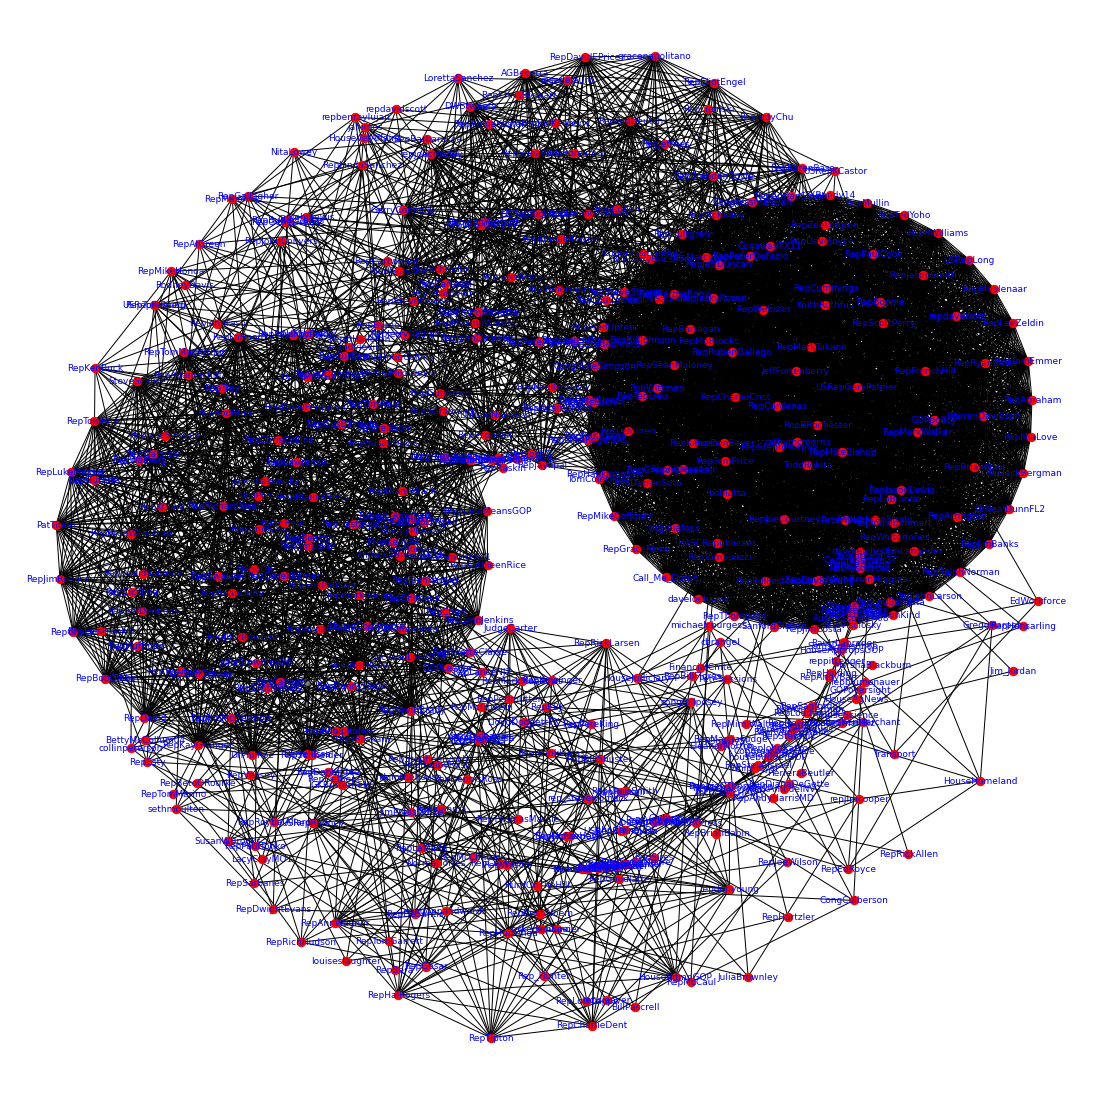

In [ ]:
plt.figure(figsize = [15,15] )
nx.draw_kamada_kawai(G,
        node_size = 70,
        with_labels = True,
         font_color="b",
         node_color='r',
         font_size='9')

##Visualizando un subconjunto

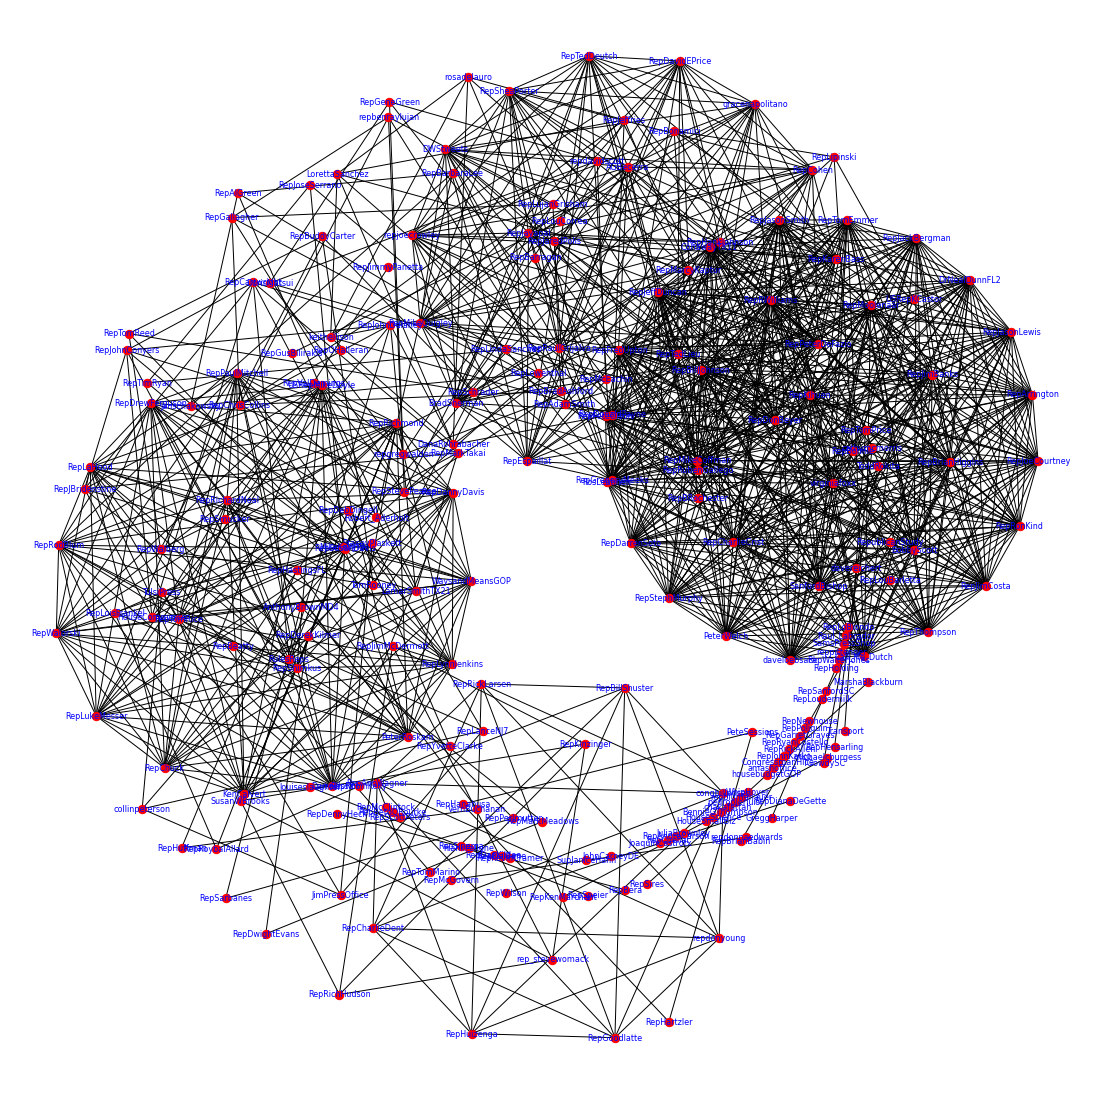

In [ ]:
import random
random.seed(123)

subG=random.choices(lista_Usuarios, k=320) #Usamos el 70% de los nodos en una selección aleatoria

G2=G.subgraph(subG)

plt.figure(figsize = [15,15] )
nx.draw_kamada_kawai(G2,
        node_size = 70,
        with_labels = True,
         font_color="b",
         node_color='r',
         font_size='8')

##3. Visualizaremos la centralidad de Grado y centralidad Closeness

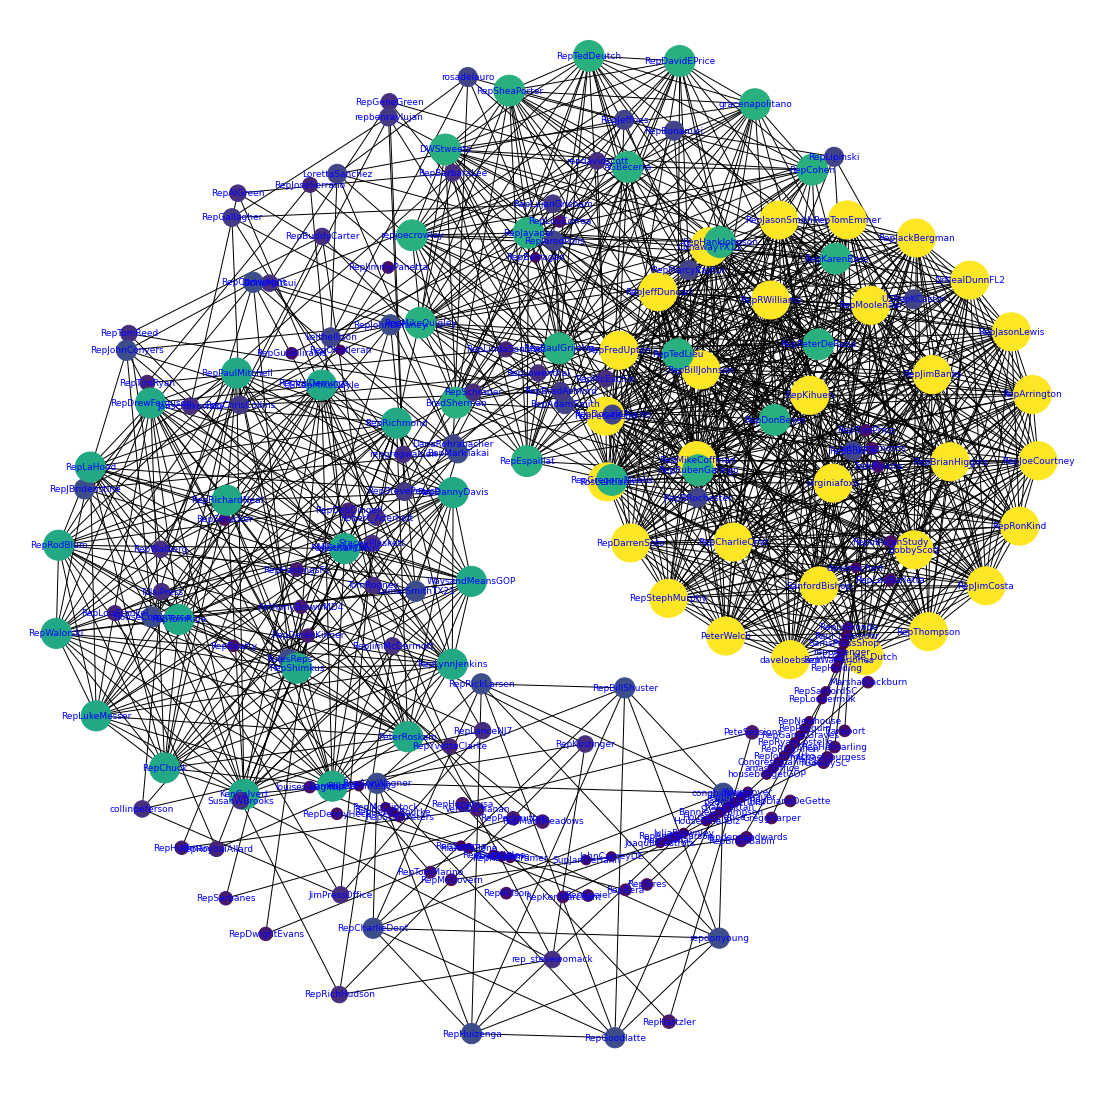

In [ ]:
diccionario = nx.degree_centrality(G2)
diccionario2 = nx.closeness_centrality(G2)

sizes = np.array([diccionario[i] for i in G2])
colors = np.array([diccionario2[i] for i in G2])

plt.figure(figsize = [15,15] )
nx.draw_kamada_kawai(G2,
        node_size = sizes*10000,
        with_labels = True,
         font_color="b",
         node_color=colors,
         cmap='viridis',
         font_size=9)

Podemos ver que la red forma cúmulos de nodos en donde están fuertemente coenctados entre ellos, si es más denso cada conjunto, el tmaño del nodo, o sea la centralidad de grado será mayor y así mismo esto también es proporcional para la centralidad de closeness

##4. Medidas de nodos

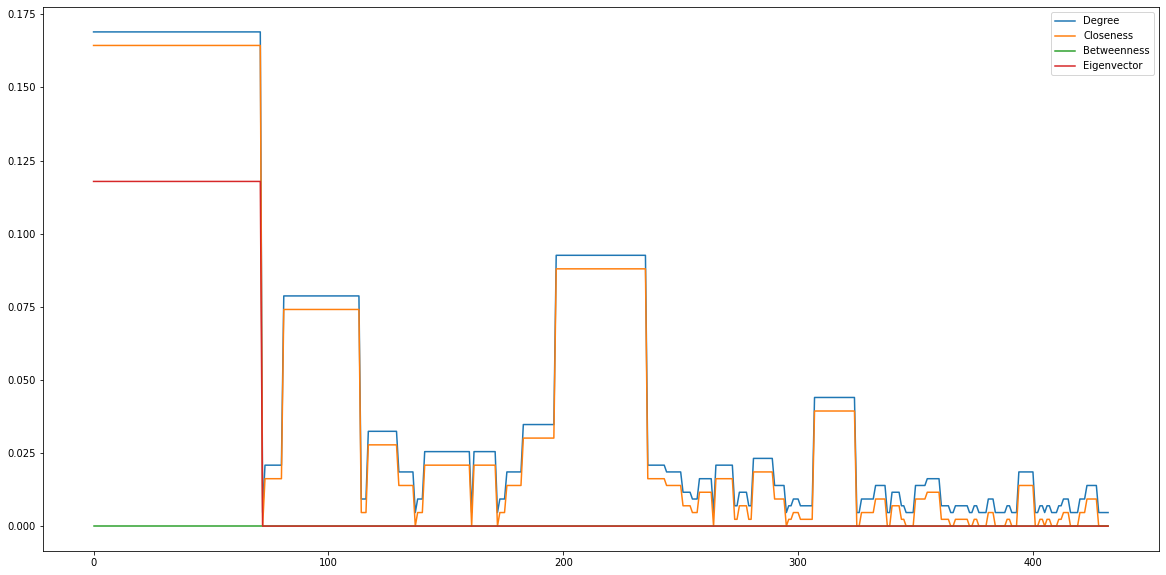

In [ ]:
diccionarioG1 = nx.degree_centrality(G)
d = np.array([diccionarioG1[i] for i in G])

diccionarioG2 = nx.closeness_centrality(G)
c = np.array([diccionarioG2[i] for i in G])

diccionarioG3 = nx.betweenness_centrality(G)
b = np.array([diccionarioG3[i] for i in G])

diccionarioG4 = nx.eigenvector_centrality(G)
e = np.array([diccionarioG4[i] for i in G])


plt.figure(figsize = [20, 10])
plt.plot(d, label = 'Degree')
plt.plot(c, label = 'Closeness')
plt.plot(b, label = 'Betweenness')
plt.plot(e, label = 'Eigenvector')

plt.legend()

Se puede observar claramente que existe una correlación entre la centralidad de grado y centralidad de Clossenes, esto se puede explicar con la forma tan peculiar en la que se agrupan los nodos, en esta red los nodos con mayor grado serán los que se encuentran en alguno de los grupos que se pueden ver en la representación de la red, y por lo mismo una centralidad de closeness más alta o lo que es lo mismo, que se encuentra más cerca de los demás nodos. 

##5. Distribución de Grado

Vemos si cumple las condciones de una red aleatoria

Propiedades generales de tu red:
- El número de nodos es:	 433
- El número de enlaces es:	 5054
- El grado promedio es:		 23.344110854503466


El coeficiente de clustering promedio de la red es:
 0.8175519630484989

El coeficiente de clustering que tendría la red si fuera aleatoria (es decir p) es:
 0.05403729364468395


Text(0.5, 0, 'k')

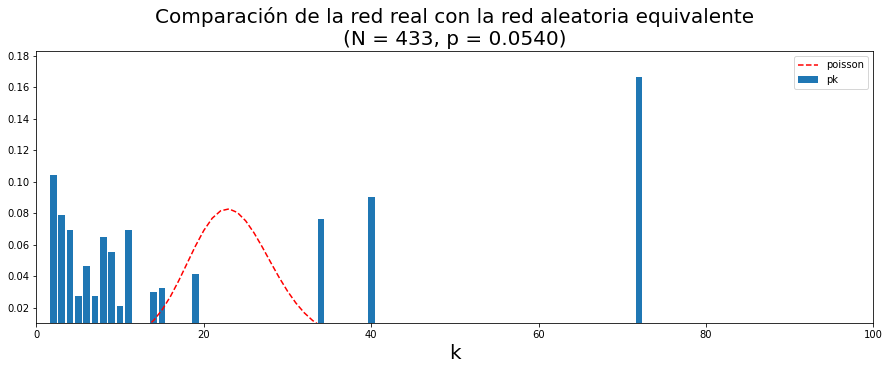

In [ ]:
from scipy.stats import poisson

N = len(G)
L = len(G.edges)
k = 2*L/N
C = nx.average_clustering(G)

p = k / (N-1)
print('Propiedades generales de tu red:')
print('- El número de nodos es:\t', N)
print('- El número de enlaces es:\t', L)
print('- El grado promedio es:\t\t', k)

print('\n\nEl coeficiente de clustering promedio de la red es:\n', C)
print('\nEl coeficiente de clustering que tendría la red si fuera aleatoria (es decir p) es:\n', p)








grado_dict = dict(nx.degree(G))
clustering_dict = nx.clustering(G)

df = pd.DataFrame([grado_dict, clustering_dict]).T
df.columns = ['Degree', 'Clustering']
#df.head()
df.Degree
K = df.Degree.max()

y,x = np.histogram(df.Degree.values, bins = range(int(K)+1), density= True)

plt.figure(figsize = [15,5])
plt.bar(x[:-1], y, label = 'pk')
plt.plot(x[:-1], poisson.pmf(x[:-1], k), 'r--', label = 'poisson') 

plt.ylim([0.5*y[y>0].min(),1.1*y.max()])
plt.xlim([0,100])
plt.legend()
plt.title('Comparación de la red real con la red aleatoria equivalente\n(N = %i, p = %.4f)' %(N,p), size = 20)
plt.xlabel('k', size = 20)





Evidentemente no se comporta como una red aleatoria

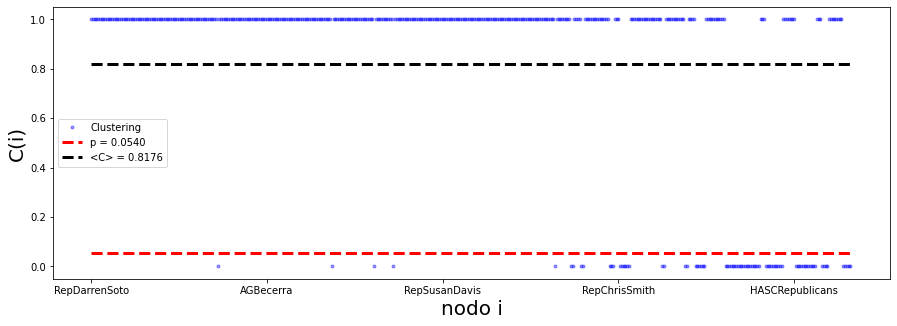

In [ ]:
plt.figure(figsize = [15,5])
df.Clustering.plot(style = 'b.', alpha = .4)

plt.plot([0,N], [p,p], 'r--', linewidth = 3, label = 'p = %.4f' %p)
plt.plot([0,N], [C,C], 'k--', linewidth = 3, label = '<C> = %.4f' %C)

plt.xlabel('nodo i', size = 20)
plt.ylabel('C(i)', size = 20)
plt.legend()

En el caso del clustering vemos que si bien no se ajustan los datos perfectamente , están relativamente 'cerca'

##Analizamos si tiene distribución de escala libre

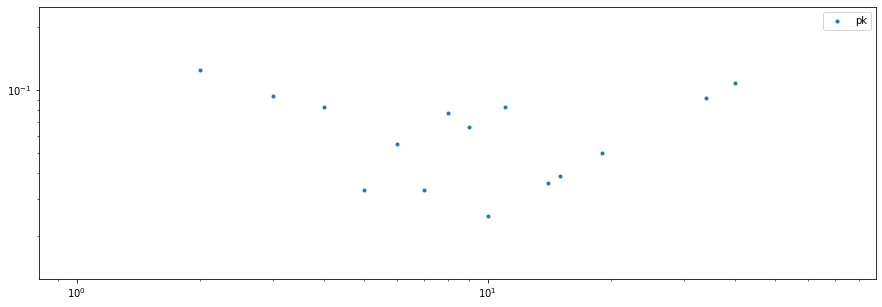

In [ ]:

grado_dict = dict(nx.degree(G))
Degree = np.array([grado_dict[nodo] for nodo in G])
K = Degree.max()
y,x = np.histogram(Degree, bins = range(int(K)), density= True)
plt.figure(figsize = [15,5])
plt.plot(x[:-1], y, '.', label = 'pk')
#plt.plot(x[:-1], poisson.pmf(x[:-1], k), 'r--', label = 'poisson')
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.5*y[y>0].min(),2*y.max()])
plt.legend()

Vemos que no cumple una distribución de escala libre, o por lo menos no lo podemos ver con los datos disponibles. Igual y con muchos más datos se pueda llegar a una mejor conclusión, ya que en este caso no contamos con demasiados datos 

Es curiosos este caso, por que no se asemeja a alguna red que hayamos visto antes, es algo incongruente esta red, específcamente con los grados, están muy dispersos los datos y en relidad es difícil llegar a alguna coclusión con las g´raficas obtenidas

Lo único importante que hay que resaltar es que el coeficiente de clustering es relativamente alto en la mayoría de los casos, que como podemos ver hay dos opciones, o es muy alto o muy bajo (pero en su gran mayoría alto), queriendo decir que la red es muy propensa a desarrollar grupos, esto se puede confirmar viendo la gráfica de la red que tiene un conjunto muy concentrado

##5. Conclusiones


*   **¿Obtuvieron algún resultado interesante que de luz sobre el fenómeno?**

Sinceramente lo que esperaba obetener en la visualización de la red es que se vieran dos conjuntos separados uno del otro y que que correspondieran uno a los demócratas y otro a los republicanos, sin embargo se obtuvieron varios conjuntos fuertemente  agrupados. No logré ver una relación de demócratas y republicanos en dichos conjuntos.

Además esta red no se comportó como cualquier otra red que hayamos visto en el curso, esto ya se podía ver venir desde que se vió por primera vez la representación de la red, fue euna forma muy peculiar en la que se agruparon los datos



*   **¿Qué otras ideas se podrían implementar en los datos, con más tiempo y recursos?**

Principalmente trataría de limpiar mejor los datos usando un método llamado lemmatize en el cual todas las palabras con la misma raíz se volverían la misma palabra, volviendo el vcabulario más corto y fácil de procesar

En segundo lugar trataría de colorear los nodos de los republicanos de un color y los demócaratas de otro, para ver si hay una clara distribución de ellos en la red.

También busacaría una forma más óptima para formar los enlaces de la red, ya que es un proceso tardado (para los datos que son)

Por último, taratría de usar la función de clustering de Scikit Learn para detectar las comunidades que existen en la red.
dd








##Nota extra:

Yo opino que una red del uso del lenguaje es diferente a cualquier otro fenómeno social en el que interactúen ciertos organismo, por lo cual pienso que este tipo de problemas se deben de abordar con otra metodología y esto puede variar de a cuerdo a varios factores como lo es el idioma, tiempo, población, etc